# Implicit solvation scheme tutorial

The aim of this tutorial is to act as an introduction for running SMPBE and MPE implicit solvation calculations using FHI-aims. This tutorial covers a brief overview of the theory, how to run the calculations and how to parametrize the variables for an implicit solvation calculation. 

The treatment of solvent effects in quantum mechanical calculations is of significant importance to properly describe the interactions between solute and solvent. Implicit solvation approaches are where solely the solute is treated quantum mechanically, whilst the solvent is represented as a continuum medium of specified dielectric permittivity. 

FHI-Aims supports two of these schemes. The first being the Size-modified Poisson-Boltzmann implicit approach (SMPBE), which is derived from the self-consistent continuum solvation scheme (SCCS) proposed by Andreussi et al. [1,2]. The SMPBE scheme is practically to the SCCS but includes a Stern-layer correction to account for the inclusion of counter-ions. The second scheme is the multipole moment expansion (MPE) model. [3] This is computationally cheaper than the SCCS scheme, but does not support forces, so geometry optimisations cannot be run. 

The electrostatic contribution to the free solvation energy describes the majority of the solvent effects. For SMPBE and MPE, these differ in how the shape of the solvation cavity is defined. Here, MPE uses a density isovalue ($Q_{\text{iso}}$) whilst SMPBE uses density thresholds ($\rho^{min}$ and $\rho^{max}$). The density thresholds in SMPBE represent the sections of the electron density isosurface where the dielectric permittivity switches from 1 to $\epsilon_{\text{solvent}}$, as a smoothed continuous function.

Non-electrostatic interactions to the free energy include dispersion interactions and solvent excluded volume effects. The Gibb's free energy of the non-electrostatic interactions ($\Delta G_{ne}$) can be approximated as linear functions of the surface area (O) and the cavity volume (V) with $\alpha$ and $\beta$ as prefactors.

\begin{equation*}
\Delta G_{ne} =
\alpha O + \beta V
\end{equation*}

For the purpose of this tutorial, the case of a water molecule surrounded by water under ambient conditions is considered. To set this up for the SMPBE scheme, the following code should be added to the FHI-Aims calulator object:

In [1]:
## SMPBE Implicit Solvation Model Settings
# solvent='mpb',
# dielec_func=('1','78.358',float(rhomin),float(rhomax)),
# ions_conc = 0,

Here, the solvent method requests for the 'mpb' scheme (SMPBE) to be used. For the "dielec_func" method, the arguments in order represent the type of dielectric function to be used, the bulk dielectric constant and the two density thresholds. Note that '1' represents the Andreussi and Marzari dielectric function used in the SCCS formulism. The final argument ("ions_conc") defines the concentration of the ions in the electrolyte. It is essential that this is set to zero if counter-ions are not present, so that it reverts back to the SCCS formulism. Here, the nonelectrostatic terms are automatically set to $\alpha+\gamma$ = 50 dyn/cm and $\beta$ = −0.35 GPa. This is the best-performing parametrisation set proposed by Andreussi et al. (formally the fit03+$\beta$ set) [2]. 

To set the same calculation up for MPE, the following code should be added to the FHI-Aim calculator object:

In [2]:
## MPE Implicit Solvation Model Settings
# solvent='mpe',
# mpe_solvent_permittivity=78.385,
# isc_cavity_type=('rho_free', float(Q_iso)),
# mpe_nonelectrostatic_model=('linear_OV', float(alpha), float(beta)), 

Here, the "mpe_solvent_permittivity" method specifies the bulk dielectric constant of water. The "isc_cavity_type" method contains the "type" and "density isovalue" arguments. The type of cavity is specified as 'rho_free' which specifies for the iso-density surface to be defined as overlapping densities of the solute atoms. The final method ("mpe_nonelectrostatic_model") specifies the non-electrostatic parametrization constants $\alpha$ and $\beta$, which (if not specified) are set to zero.

The original Andreussi and Sinstein et al. papers propose parametrisation constants for PBE and a small scope of other functionals, benchmarked against large testsets of free solvation energies. [2,3] However, it is often desirable to use other functionals, to properly describe the electronic properties of a given molecule. Sinstein et al. highlight that the functional and basis set chosen play a significant role in the solvation parameters. [3] Therefore, it is of use to be able to parametrize a solvation model for a given functional and basis set. To do this we run a number of implicit solvation calculations whilst varying the values of $\rho^{min}$ and $\rho^{max}$. Here, given the lesser effect of non-electrostatic interactions, only the density thresholds will be parametrised.

To analyze the results, we start by importing the relevant python functions:

In [3]:
import sys
sys.path.append("../")
from scripts.solvation import mpb_solv

To calculate the free solvation energy, the optimised energy of the solute in gas-phase must be subtracted from the "| Free Energy in Electrolyte" in each aims.out of the folder containing the data. 

In [4]:
folder = "H2O"
solute_energy =  -2080.932940067  #(water with pbe0 + tight basis)

Next, the rhomin and rhomax used in the calculation are defined as a numpy array. The mpb_solv function takes these variables as arguments, extracts the optimised free solvation energy for each $\rho^{min}$, $\rho^{max}$ permutation and stores the data to a pandas dataframe.

In [5]:
import numpy
rhomin = numpy.arange(0.00010, 0.00045, 0.00005) #(initial, final, step size)
rhomax = numpy.arange(0.0010,0.0045,0.0005) #(initial, final, step size)
data = mpb_solv(folder, solute_energy, rhomin, rhomax)

With the data now stored as a pandas dataframe, we can now start to manipulate the data. Below, the first five rows of the dataframe are highlighted:

In [6]:
data.head(5)

,rhomin,rhomax,Free Solvation Energy / eV
0,0.00010,0.0010,-0.117265
1,0.00010,0.0015,-0.148735
2,0.00010,0.0020,-0.173984
3,0.00010,0.0025,-0.196432
4,0.00010,0.0030,-0.216331


To assess how effective the parametrization is, we need to benchmark against the experimental free solvation energy value. For 
water, this is well characterized in literature as -0.274 eV. [2] 

In [7]:
Exp_FSE = -0.274 

The error for each parametrization permutation can be thus be calculated by subtracting "Exp_FSE" from the "Free Solvation Energy" column, followed by redefining the column values and name.

In [8]:
errors = data["Free Solvation Energy / eV"]-Exp_FSE   # calculates errors
data["Free Solvation Energy / eV"] = errors           # redefines column values
data.columns = ['rhomin', 'rhomax', 'errors']         # redefines column name

This data can be visualized using the "contour" python function, which plots the data as a contour plot. Given that contour plots require the z variable (error) to be 2D, the data must be modified to a pivot table using the pandas "pivot_table" method. It is worth highlighting that any NaN values in the pivot table are due to calculations where the optimisation convergence criteria was not met.

In [9]:
import pandas as pd
from scripts.solvation import contour
ptab = pd.pivot_table(data, index='rhomin', columns='rhomax', values='errors')
ptab

rhomax,0.0010,0.0015,0.0020,0.0025,0.0030,0.0035,0.0040
rhomin,,,,,,,
0.00010,0.156735,0.125265,0.100016,0.077568,0.057669,0.038995,0.021713
0.00015,0.142898,0.107874,0.079980,0.055373,0.033778,0.013358,-0.005435
0.00020,0.127845,0.094209,0.064072,0.037959,0.015086,-0.006689,-0.026621
0.00025,NaN,0.085291,0.053097,0.024826,0.000290,-0.022814,-0.043761
0.00030,NaN,NaN,0.042934,0.012626,-0.013126,-0.037154,-0.058876
0.00035,NaN,NaN,0.033972,0.002257,-0.024376,-0.049375,-0.071988
0.00040,NaN,NaN,0.026561,-0.005302,-0.033370,-0.059758,-0.083499


The rhomin, rhomax and errors values in the pandas pivot table can subsequently defined as the Y, X and Z variables respectively. The contour function takes these variables as arguments and produces a contour plot using matplotlib:

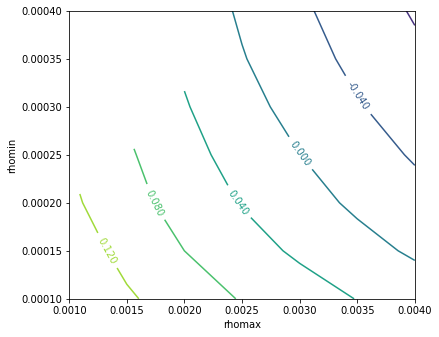

In [10]:
Y=ptab.index.values
X=ptab.columns.values
Z=ptab.values
contour(X, Y, Z)

The contour plot indicates that there is not one exclusive solution. Any $\rho^{min}$, $\rho^{max}$ combination along the isoline with a value of 0.000 yields a suitable parametrization for the water solute in water. Here, $\rho^{min}$, $\rho^{max}$ combinations such as (0.00015, 0.004) and (0.00025, 0.003) exhibit the lowest errors. 


**Notes for extending the methodology in this tutorial** 

For a qualitative treatment, calibrating a solvation environment for just water in water is adequate. This will describe the majority of the dielectric response from the solvent however it is worth noting the model will be overparametrized for water.

To develop more robust scheme, it would be necessary to determine the mean absolute error for each $\rho^{min}$, $\rho^{max}$ permutation over a range of solutes. To parametrize for other solvents than water, it requires reparametrizing the $\alpha$ and $\beta$ non-electrostatic parameters.

**References**

[1] S. Ringe, H. Oberhofer, C. Hille, Journal of Chemical Theory and Computation, 2016, 12, 8, 4052-4066

[2] O. Andreussi, I. Dabo, N. Marzari, Journal of Chemical Physics, 2012, 136

[3] M. Sinstein, C. Scheurer, S. Matera et al., Journal of Chemical Theory and Computation, 2017, 13, 11, 5582-5603